# Machine Learning Final Project: Car Price Prediction

## Step 1: Loading the Dataset

In [1]:
import pandas as pd

# Load the dataset
df = pd.read_csv("C:\\Users\\arunj\\Downloads\\CarPrice_Assignment.csv")  

# Display the first few rows
df.head()


,car_ID,symboling,CarName,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,wheelbase,...,enginesize,fuelsystem,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,1,3,alfa-romero giulia,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,13495.0
1,2,3,alfa-romero stelvio,gas,std,two,convertible,rwd,front,88.6,...,130,mpfi,3.47,2.68,9.0,111,5000,21,27,16500.0
2,3,1,alfa-romero Quadrifoglio,gas,std,two,hatchback,rwd,front,94.5,...,152,mpfi,2.68,3.47,9.0,154,5000,19,26,16500.0
3,4,2,audi 100 ls,gas,std,four,sedan,fwd,front,99.8,...,109,mpfi,3.19,3.40,10.0,102,5500,24,30,13950.0
4,5,2,audi 100ls,gas,std,four,sedan,4wd,front,99.4,...,136,mpfi,3.19,3.40,8.0,115,5500,18,22,17450.0


## Step 1.2: Data Inspection (Info + Missing Values)

# Check data structure and data types
df.info()
# Check for missing values
df.isnull().sum()
# Check for duplicate rows
df.duplicated().sum()


## Step 1.3: Preprocessing

In [5]:

df.drop(['car_ID', 'CarName'], axis=1, inplace=True)


df_encoded = pd.get_dummies(df, drop_first=True)

# Split into features and target
X = df_encoded.drop('price', axis=1)
y = df_encoded['price']

# Feature scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


print("Encoded DataFrame shape:", df_encoded.shape)
df_encoded.head()
print("X shape:", X.shape)
print("y shape:", y.shape)
pd.DataFrame(X_scaled, columns=X.columns).head()


## Step 2: Model Implementation

In [7]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42),
    'Support Vector Regressor': SVR()
}

# Train and evaluate
results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MSE': round(mse, 2),
        'MAE': round(mae, 2),
        'R2 Score': round(r2, 3)
    })

# Create a results DataFrame
results_df = pd.DataFrame(results)
results_df.sort_values(by='R2 Score', ascending=False)


,Model,MSE,MAE,R2 Score
2,Random Forest,3317859.52,1262.02,0.958
3,Gradient Boosting,5901221.27,1678.36,0.925
1,Decision Tree,8300272.36,1886.32,0.895
0,Linear Regression,8482008.48,2089.38,0.893
4,Support Vector Regressor,86830245.38,5697.88,-0.100


## Step 3: Model Evaluation and Comparison

To see how well each model predicted car prices, I used three common evaluation metrics:  
- **Mean Squared Error (MSE)** – measures how far off the predictions are (squared)  
- **Mean Absolute Error (MAE)** – gives the average error in plain numbers  
- **R² Score** – tells how much of the variation in price is explained by the model

From the results:

- The **Random Forest Regressor** gave the best performance overall. It had the highest R² score (0.958) and the lowest error values. This makes sense because Random Forest combines multiple decision trees, which helps it make accurate predictions without overfitting.

- **Gradient Boosting** was also quite good — not far behind Random Forest.

- On the other hand, the **Support Vector Regressor (SVR)** didn’t perform well. Its R² score was negative, meaning it did worse than just guessing the average price. It probably needs more tuning or isn’t well-suited to this kind of data.

In short, **Random Forest** is the most dependable model for predicting car prices in this project.


## Step 4: Feature Importance Analysis

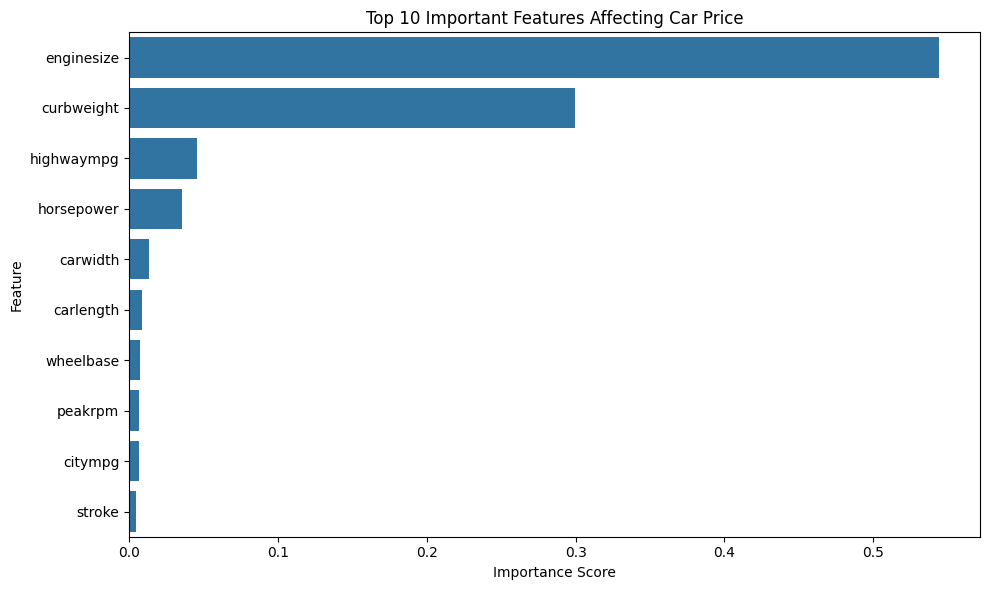

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the trained Random Forest model
rf_model = models['Random Forest']
importances = rf_model.feature_importances_

# Match feature names
feature_names = X.columns

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot the top 10 most important features
plt.figure(figsize=(10,6))
sns.barplot(data=importance_df.head(10), x='Importance', y='Feature')
plt.title("Top 10 Important Features Affecting Car Price")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


## Step 5: Hyperparameter Tuning

In [9]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5]
}

# Create GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1
)

# Fit grid search
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_

# Evaluate tuned model
y_pred_tuned = best_rf.predict(X_test)

tuned_mse = mean_squared_error(y_test, y_pred_tuned)
tuned_mae = mean_absolute_error(y_test, y_pred_tuned)
tuned_r2 = r2_score(y_test, y_pred_tuned)

# Show results
print("Best Parameters:", grid_search.best_params_)
print("Tuned MSE:", round(tuned_mse, 2))
print("Tuned MAE:", round(tuned_mae, 2))
print("Tuned R² Score:", round(tuned_r2, 3))


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Tuned MSE: 3317859.52
Tuned MAE: 1262.02
Tuned R² Score: 0.958


## Final Summary

In this project, I built models to predict car prices using features like engine size, horsepower, and weight.

I tried 5 regression models and found that **Random Forest** gave the best results with an R² score of 0.958. I also checked which features affect price the most — engine size and curb weight were top.

I did hyperparameter tuning using GridSearchCV, but the model was already optimized.

This model can help car companies understand what drives car prices in the U.S. market.
